## 1 线性回归的从零开始实现
数据流水线、模型、损失函数和小批量随机梯度下降优化器

*Env: d2l*

In [58]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

根据带有噪声的线性模型构造一个人造数据集合。我们使用线性模型参数 w = [2, -3.4]T、 b = 4.2和噪声项c生成数据集及其标签

In [59]:
def synthetic_data(w, b, num_examples):
    """生成 y = Xw + b + 噪声。"""
    x = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(x, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return x, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [60]:
features.shape, labels.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

`features`中的每一行都包含一个二维数据样本，`labels`中的每一行都包含一维标签值(一个标量)

In [61]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-1.8080,  0.1601]) 
label: tensor([0.0368])


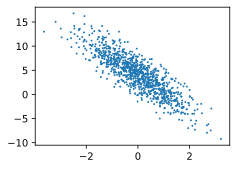

In [62]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(),
                labels.detach().numpy(), 1);

定义一个`data_iter`函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量

In [63]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    print(X.shape), print(y.shape)
    break

tensor([[ 9.8745e-02, -1.7486e+00],
        [-1.6454e+00, -2.8422e-01],
        [-4.4723e-01,  2.3694e-01],
        [-1.0056e-03, -5.9452e-01],
        [-5.3578e-01,  4.8965e-01],
        [-4.0361e-01,  2.1749e+00],
        [-7.6252e-01, -1.1756e+00],
        [-1.8679e+00,  5.7317e-02],
        [-1.0140e-01, -8.6203e-02],
        [-6.4804e-02,  1.6826e-01]]) 
 tensor([[10.3439],
        [ 1.8855],
        [ 2.5076],
        [ 6.2360],
        [ 1.4597],
        [-4.0011],
        [ 6.6729],
        [ 0.2707],
        [ 4.2807],
        [ 3.5206]])
torch.Size([10, 2])
torch.Size([10, 1])


定义初始化模型参数

In [64]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
w.shape, b.shape

(torch.Size([2, 1]), torch.Size([1]))

定义模型

In [65]:
def linreg(X, w, b):
    """线性回归模型。"""
    return torch.matmul(X, w) + b

定义损失函数

In [66]:
def squared_loss(y_hat, y):
    """均分损失"""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

定义优化算法

In [67]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降。"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [68]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # `X`和`y`的小批量损失
        # 因为`l`形状是(`batch_size`, l), 而不是一个标量。`l`中的所有元素被加到
        # 并以此计算关于[`w`, `b`]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size) # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f"epoch {epoch + 1}, loss {float(train_l.mean())}")

epoch 1, loss 0.03562371805310249
epoch 2, loss 0.00012925054761581123
epoch 3, loss 4.897729377262294e-05
